In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import sys

SRC = Path("__file__").resolve().parents[1]
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

import config as cfg

In [6]:
# Load weather data
weather_path = cfg.INT_WTH /"weather_filtered.parquet"
print(f"Loading: {weather_path}")
df = pd.read_parquet(weather_path)

# --- Basic Info ---
print("Shape (rows, cols):", df.shape)
print("\nMissing values per column:\n", df.isna().sum())


Loading: D:\Air pollution london\data\interim\weather\weather_filtered.parquet
Shape (rows, cols): (321240, 11)

Missing values per column:
 location_id                       0
time                              0
temperature_2m (°C)               0
rain (mm)                         0
snowfall (cm)                     0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
surface_pressure (hPa)            0
cloud_cover (%)                   0
dtype: int64


In [8]:
# --- Timestamp Checks ---
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['weekday'] = df['time'].dt.weekday  # 0 = Monday
df['hour'] = df['time'].dt.hour

print("\n--- Time Coverage Summary ---")
print("Years in data:", sorted(df['year'].unique()))
print("Months in data:", sorted(df['month'].unique()))
print("Weekdays in data:", sorted(df['weekday'].unique()))
print("Hours in data:", sorted(df['hour'].unique()))

# --- Validation against spec ---
valid_years = df['year'].between(2010, 2023)
valid_months = df['month'].between(3, 10)
valid_weekdays = df['weekday'].between(0, 4)
valid_hours = df['hour'].between(7, 18)

filtered_df = df[valid_years & valid_months & valid_weekdays & valid_hours]
print(f"\nRecords matching time filter: {len(filtered_df):,} / {len(df):,} "
      f"({(len(filtered_df) / len(df)) * 100:.2f}%)")



--- Time Coverage Summary ---
Years in data: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Months in data: [3, 4, 5, 6, 7, 8, 9, 10]
Weekdays in data: [0, 1, 2, 3, 4]
Hours in data: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

Records matching time filter: 291,600 / 321,240 (90.77%)


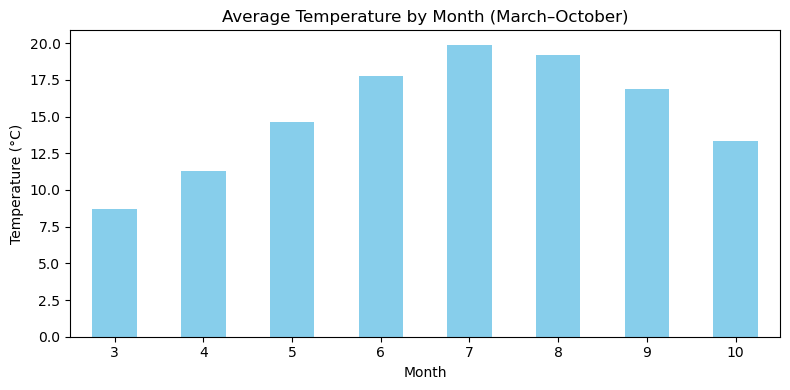

In [10]:
# 1. Average temperature by month
temp_by_month = df.groupby('month')["temperature_2m (°C)"].mean()
plt.figure(figsize=(8, 4))
temp_by_month.plot(kind='bar', color='skyblue')
plt.title("Average Temperature by Month (March–October)")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

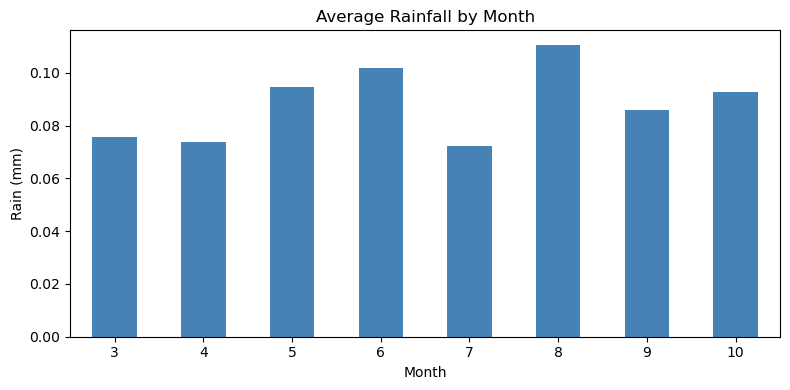

In [24]:
# 2. Average rain per hour
rain_by_month = df.groupby('month')["rain (mm)"].mean()
plt.figure(figsize=(8, 4))
rain_by_month.plot(kind='bar', color='steelblue')
plt.title("Average Rainfall by Month")
plt.xlabel("Month")
plt.ylabel("Rain (mm)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

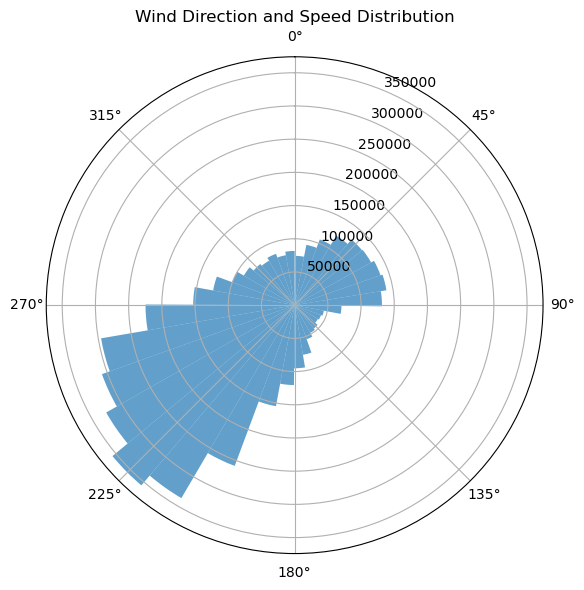

In [18]:
# 3. Wind Direction Distribution (Wind Rose-style Polar Plot)
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
wind_rad = np.radians(df["wind_direction_10m (°)"])
ax.hist(wind_rad, bins=36, weights=df["wind_speed_10m (km/h)"], alpha=0.7)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.title("Wind Direction and Speed Distribution")
plt.tight_layout()
plt.show()

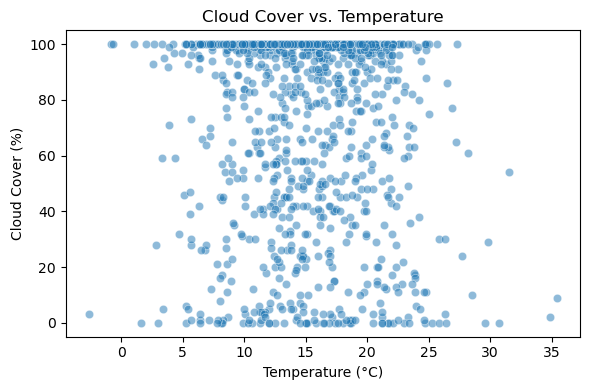

In [20]:
# 4. Cloud Cover vs Temperature Scatter
sample_df = df.sample(1000, random_state=42)
plt.figure(figsize=(6, 4))
sns.scatterplot(data=sample_df,
                x="temperature_2m (°C)", y="cloud_cover (%)",
                alpha=0.5)
plt.title("Cloud Cover vs. Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Cloud Cover (%)")
plt.tight_layout()
plt.show()